In [171]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 7)

coffee = pd.read_csv('data/coffee.csv', index_col=0)

true = pd.read_csv('data/missing_true.csv')
unif = pd.read_csv('data/missing_unif.csv')
depd = pd.read_csv('data/missing_depd.csv')

def plot_distributions(**kwargs):
    '''plot two series/'''
    L = [v.assign(missing=k) for (k, v) in kwargs.items()]
    title = 'distribution of value'
    G = pd.concat(L).groupby('missing')['value']
    return G.plot(kind='hist', legend=True, title=title, bins=15, density=True, alpha=0.5)

# Single-Valued Imputation
---

Missing-value imputation refers to the process of 'filling-in' missing data with values that approximate the *true value* of the missing observation. Since the true value is unknown, various imputation techniques use different reasoning to make a 'best guess' at what the true values of these observations.

Single-valued imputation make deterministic best guesses: a given missing observation will *always* be imputed with the same value. This well-behaved procedure has trade-offs: while easy to understand implement and interpret, it biases many statistics of the dataset. In particular single-valued imputation almost always artificially decreases the variance of a dataset; this decrease inflates the confidence one has in the results of one's inference.

The trick of single-valued imputation lies in how one finds the values with which to impute. This process may vary from an ad-hoc fixed value, to more complicated rules and models that statistically predict the missing value. The portions below introduce different imputation techniques in increasing complexity.

## Imputation with the Mean/Mode

Imputation with a 'typical' value of a column is the most simple approach to imputation. To impute a column with its mean value, one need only pass a dictionary of values to `fillna`: the keys are the columns to be imputed, while the values are mean values for those columns.

### MCAR Data

**Example (Mean):** Imputing the `value` column with the mean observed value:

In [172]:
imputed = unif.fillna({'value': unif['value'].mean()})

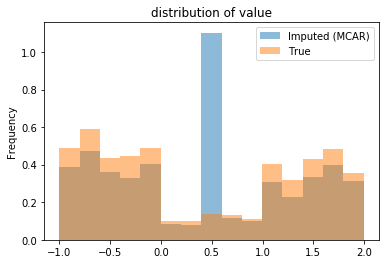

In [173]:
d = {
    'True': true,
    'Imputed (MCAR)': imputed
}
plot_distributions(**d);

From the plot, one observes the imputed distribution looks *very* different; all the missing values were given a single value. This decision has two primary effects:
* the mean remains unchanged by construction, and
* the variance of the imputed data is much smaller.

These effects are seen in the following table:

In [174]:
pd.concat([
    imputed.assign(missing='Imputed'), 
    true.assign(missing='True Pop')]
).groupby('missing').describe()

value                                                              \
           count      mean       std       min       25%       50%       75%   
missing                                                                        
Imputed   1000.0  0.414235  0.888919 -0.999003 -0.371867  0.414235  1.217879   
True Pop  1000.0  0.407980  0.989372 -0.999143 -0.532888  0.131755  1.404898   

                    
               max  
missing             
Imputed   1.994737  
True Pop  1.994737

**Example (Mode):** Imputing categorical attributes with the most 'typical' value calls for using the *mode*, as computing means only makes sense for quantitative columns. For the categorical attribute 'label', the most common value is `C`. 

Imputation with the mode therefore sees a large increase in the occurrence of the value `C`:

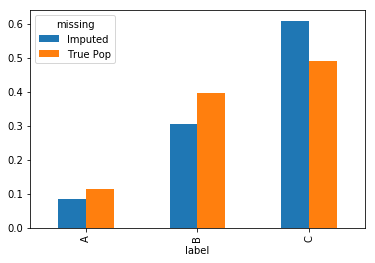

In [175]:
pd.concat([
    unif.fillna({'label': unif['label'].mode().squeeze()}).assign(missing='Imputed'), 
    true.assign(missing='True Pop')]
).pivot_table(index='label', columns='missing', aggfunc='size').apply(lambda x:x/x.sum()).plot(kind='bar');

### MAR Data

Imputing MAR data with the mean yields a biased estimate of the true mean:

In [176]:
imputed = depd.fillna({'value': depd['value'].mean()})

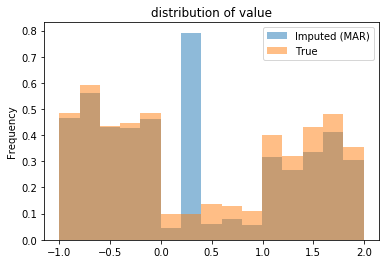

In [177]:
d = {
    'True': true,
    'Imputed (MAR)': imputed
}
plot_distributions(**d);

Note that, not only is the standard deviation smaller, but so is the mean of the dataset:

In [178]:
pd.concat([
    imputed.assign(missing='Imputed'), 
    true.assign(missing='True Pop')]
).groupby('missing').describe()

value                                                              \
           count      mean       std       min       25%       50%       75%   
missing                                                                        
Imputed   1000.0  0.335408  0.930277 -0.999143 -0.508812  0.335408  1.240418   
True Pop  1000.0  0.407980  0.989372 -0.999143 -0.532888  0.131755  1.404898   

                    
               max  
missing             
Imputed   1.994737  
True Pop  1.994737

**Example (Mean-by-group):** Since the missingness of the 'value' column is dependent on 'label', the biased estimate of the mean can be corrected by doing *group-wise* single-valued imputation with the mean:

In [184]:
def fillna_grp(ser):
    '''fill-na with mean for a column for a column'''
    return ser.fillna(ser.mean())
    
imputed = depd.assign(
        value=depd.fillna({'label':'NULL'}).groupby('label')['value'].transform(fillna_grp)
)

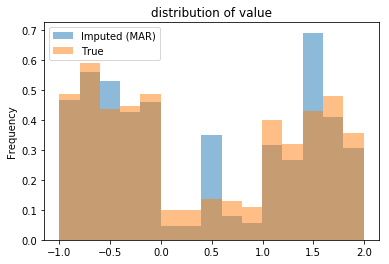

In [185]:
d = {
    'True': true,
    'Imputed (MAR)': imputed
}
plot_distributions(**d);

Note that the three peaks correspond to the single-valued imputation for the three groups. The table below shows the mean of the imputed dataset roughly matches the population mean:

In [181]:
pd.concat([
    imputed.assign(missing='Imputed'), 
    true.assign(missing='True Pop')]
).groupby('missing').describe()

value                                                             \
           count     mean       std       min       25%       50%       75%   
missing                                                                       
Imputed   1000.0  0.41524  0.987724 -0.999143 -0.511413  0.311839  1.482188   
True Pop  1000.0  0.40798  0.989372 -0.999143 -0.532888  0.131755  1.404898   

                    
               max  
missing             
Imputed   1.994737  
True Pop  1.994737

*Remark:* That the standard deviations are that close is likely due to the particulars of this dataset. Generally, group-wise single-valued imputation would still underestimate the variance of the population.

## Imputation with Complex Models

Each of the above techniques takes advantage of the observed data to make a best guess at the true value of a missing observation. Imputation with the mean uses the mean of observed empirical distribution of the attributed being imputed; group-wise imputation with the mean uses the conditional distribution, taking advantage of the attribute's dependency on another column.

Similar approaches, using more complex models, predict the true value of missing data using all attributes in the dataset. Examples of these include:
* fitting a linear regression model on the observed data to impute a given column,
* fitting a k-nearest neighbors (k-NN) model to impute a given column.

Each of these consider the missing observations as a target variable to be predicted. These techniques will be covered when discussing modeling, later in the course.